In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import pickle
import sys
import os
from os import listdir
import argparse
import math
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC # "Support vector classifier"
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sklearn.model_selection as model_selection
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn import metrics
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation 
from tensorflow.keras.optimizers import Adam

!git clone https://github.com/bjarreau/ML4MI.git

fatal: destination path 'ML4MI' already exists and is not an empty directory.


In [2]:
######## common operations ##########

#read data from a csv and split to attributes and labels
def read_csv(path):
    for file in os.listdir(path):
        if file.endswith(".csv"):
            data = pd.read_csv(f"{path}/{file}")
    xs = data.drop(["Label"], axis=1)
    ys = data["Label"]
    return (xs, ys)
    
#create accuracy and error curves and save to file
def summarize_diagnostics(history, out, method):
    plt.clf()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.savefig("{}/METRICS/{}_accuracy.png".format(out, method))
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.savefig("{}/METRICS/{}_loss.png".format(out, method))
    plt.show()

#compute the performance measures, graph, and save to file
def get_scores(acc, labels, prediction, title, method, out):
    f1 = metrics.f1_score(labels, prediction)
    conf_matrix = metrics.confusion_matrix(labels, prediction)
    sens = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    spec = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    auc = metrics.roc_auc_score(labels, prediction)
    
    plt.clf()
    plt.bar("Sensitivity", sens, label="{} Sensitivity".format(method))
    plt.bar("Specificity", spec, label="{} Specificity".format(method))
    plt.bar("AUC", auc, label="{} AUC".format(method))
    plt.bar("F1", f1, label="{} F1".format(method))
    plt.bar("Accuracy", acc, label="{} ACC".format(method))
    plt.savefig("{}/METRICS/{}_{}_metrics.png".format(out, method, title))
    plt.show()
  
#get the limits of the graph for use in decision function
#def decision_function(model, ax = None, plot_support = True):
#   if ax is None:
#      ax = plt.gca()
#   xlim = ax.get_xlim()
#   ylim = ax.get_ylim()

# read data from directory and split to relevant datasets
def read_data(inp):
  X_train = pd.DataFrame()
  X_test = pd.DataFrame()
  X_validation = pd.DataFrame()
  y_train = []
  y_test = []
  y_validation = []

  for filename in os.listdir(inp):
    if filename == "TRAIN":
        X_train, y_train = read_csv(f"{inp}/{filename}")
    elif filename == "TEST":
        X_test, y_test = read_csv(f"{inp}/{filename}")
    elif filename == "VALIDATION":
        X_validation, y_validation = read_csv(f"{inp}/{filename}")  
  return X_train, y_train, X_test, y_test, X_validation, y_validation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                220       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 682
Trainable params: 682
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
2/2 [==============================] - 1s 568ms/step - loss: 57.1833 - accuracy: 0.3333 - val_loss: 52.1016 - val_accuracy: 0.3611
Epoch 2/100
2/2 [==============================] - 0s 71ms/step - loss: 55.6421 - accuracy: 0.3333 - val_loss: 50.4732 - val_accuracy: 0.3611
Epoch 3/100
2/2 [==============================] - 0s 91ms/step - loss: 54.0895 - accuracy: 0.3333 - val_loss: 48.8526 - val_accuracy: 0.3611
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 52.5969 - accuracy: 0.3333 - val_loss: 47.2342 - val_accuracy: 0.3611
Epoch 5/100
2/2 [==============================] - 0s 72ms/step - loss: 51.0364 - accuracy: 0.3333 - val_loss: 45.6212 - val_accuracy: 0.3611
Epoch 6/100
2/2 [==============================] - 0s 37ms/step - loss: 49.5446 - accuracy: 0.3333 - val_loss: 44.0150 - val_accuracy: 0.3611
Epoch 7/100
2/2 [==============================] - 0s 64ms/step - loss: 48.0083 - accuracy: 0.3333 - val_loss: 42.4289 - val_accuracy: 0.3611
Epoch

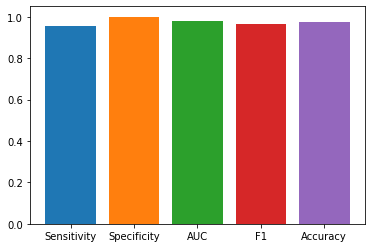

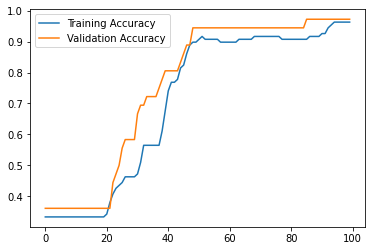

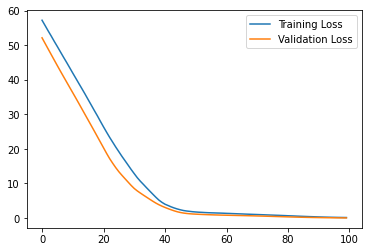

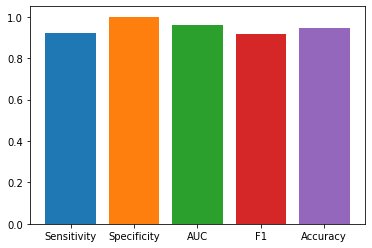

INFO:tensorflow:Assets written to: ram://5653afb9-2421-4fbf-b114-56a066640ec9/assets


In [3]:
######### ANN Section ##########
earlystop = True
activation = "relu"
learningrate = 0.00025
output = "/content/ML4MI/OUTPUT/"
input = "/content/ML4MI/INPUT/"

X_train, y_train, X_test, y_test, X_validation, y_validation = read_data(input)

model = Sequential([
    Dense(20, input_dim=10, activation=f'{activation}'),
    Dense(20, activation=f'{activation}'),
    Dense(2, activation='softmax')
])

model.compile(Adam(lr=float(learningrate)), loss="sparse_categorical_crossentropy", metrics=['accuracy'])   
model.summary()

if earlystop:
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1, min_delta=0.001)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[callback], epochs=100, batch_size=64)
else:
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

predictions = model.predict(X_test)
predictions=np.argmax(predictions,axis=1)
acc = accuracy_score(y_test, predictions)
get_scores(acc, y_test, predictions, "test", "ANN", output)
summarize_diagnostics(history, output, "ANN")

predictions = model.predict(X_validation)
predictions=np.argmax(predictions,axis=1)
acc = accuracy_score(y_validation, predictions)
get_scores(acc, y_validation, predictions, "validation", "ANN", output)    

pickle.dump(model, open("{}/MODEL/ANN.sav".format(output), 'wb'))

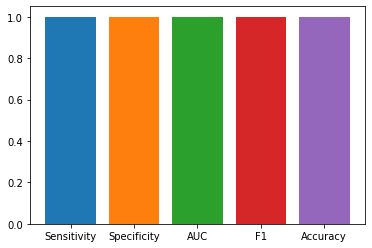

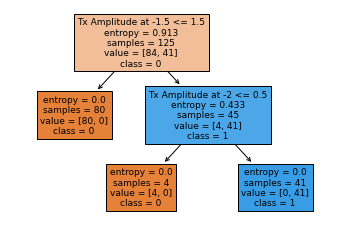

In [4]:
################## DT Section #######################
criteria = "entropy" # criteria to use for Decision Tree: entropy or gini
depth = 5 # cutoff depth of tree
output = "/content/ML4MI/OUTPUT"
input = "/content/ML4MI/INPUT/DT"

(X_train, y_train, X_test, y_test, X_validation, y_validation) = read_data(input)

tree = DecisionTreeClassifier(criterion = criteria).fit(X_train, y_train)  
prediction = tree.predict(X_test)   
acc = tree.score(X_test, y_test)
get_scores(acc, y_test, prediction, "test", "DT", output)

_ = plot_tree(tree, max_depth=int(depth), feature_names=X_train.columns[:-1], class_names=['0','1'], filled=True)
plt.savefig("{}/METRICS/decision_tree.png".format(output), format='png', bbox_inches = "tight")
plt.show()

pickle.dump(tree, open("{}/MODEL/decision_tree.sav".format(output), 'wb'))

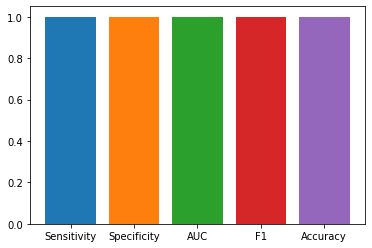

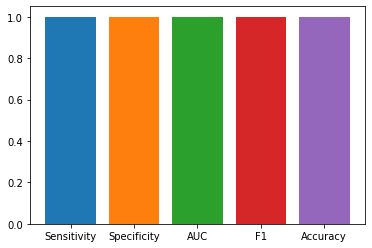

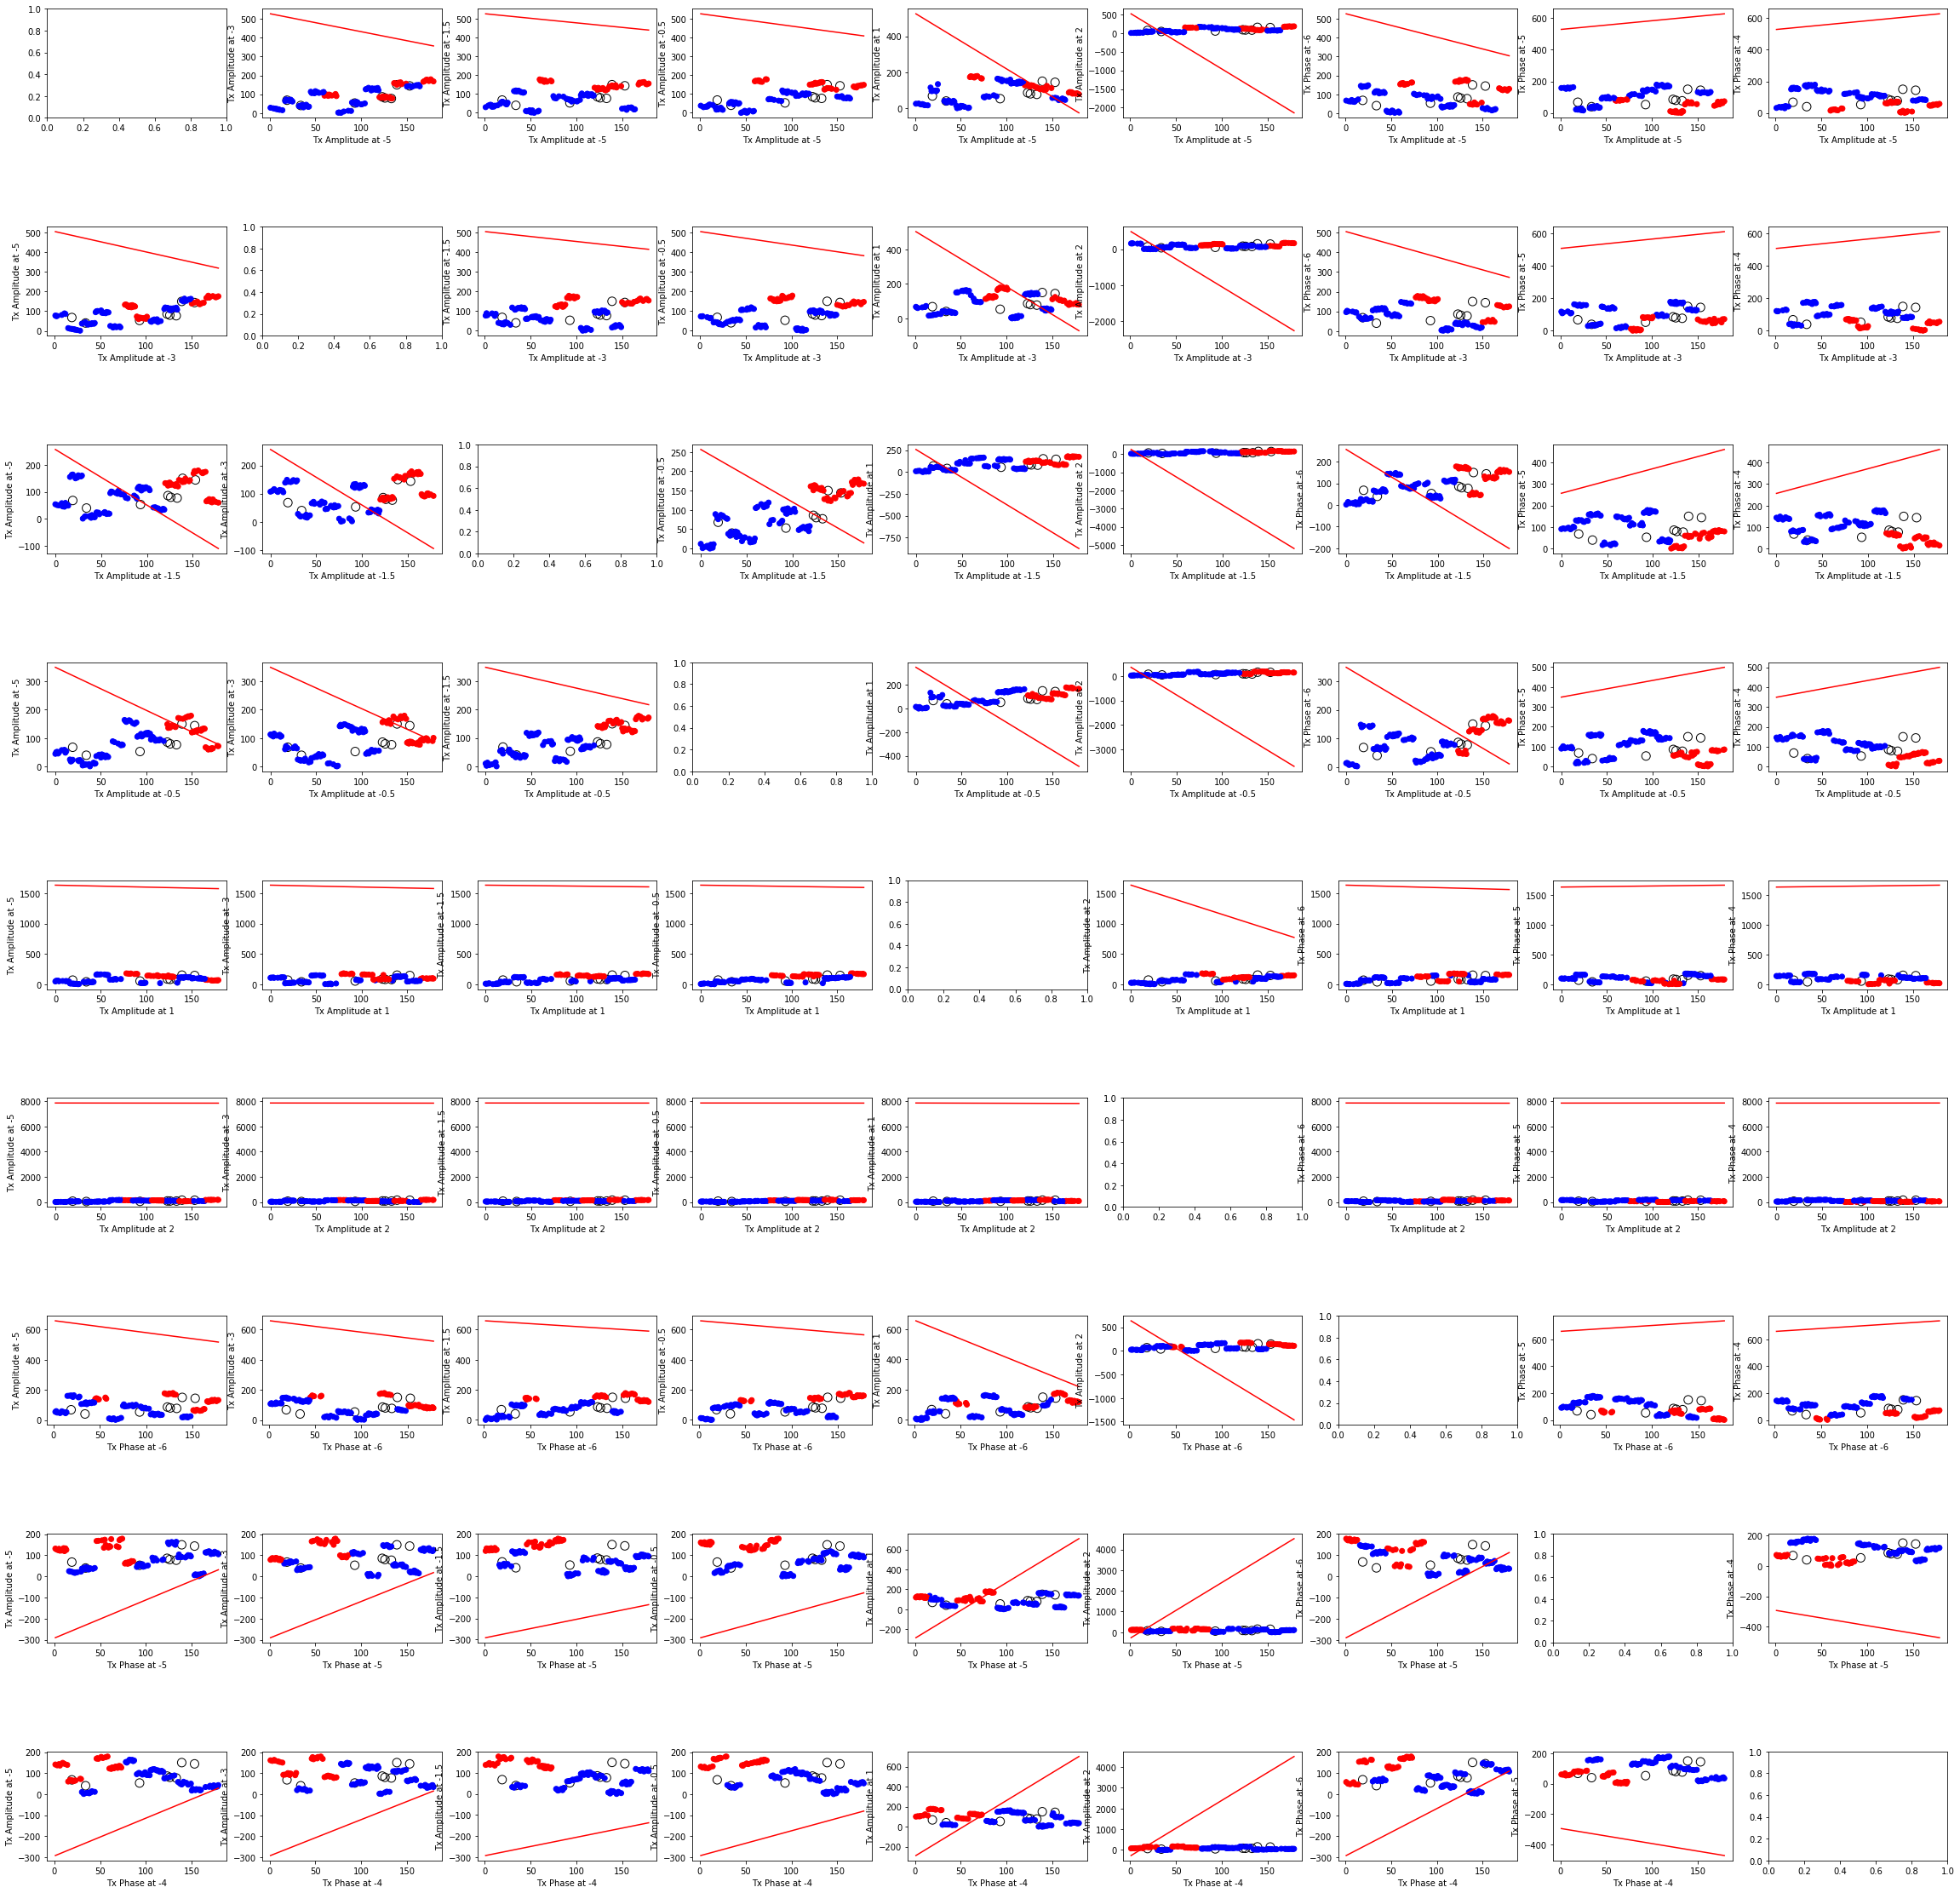

<Figure size 432x288 with 0 Axes>

In [5]:
################## SVM Section #######################
kernel = "linear"  # kernel type for SVM: linear, poly, rbf, sigmoid, precomputed
regularization = 1.0 # regularization amount for SVM (must be positive), 2 models will run with C and 2C
output = "/content/ML4MI/OUTPUT/"
input = "/content/ML4MI/INPUT/"

def plot_boundaries():
  for i in range(len(X_train.keys()) - 1):
    key1 = X_train.keys()[i]
    for j in range(len(X_train.keys()) - 1):
      key2 = X_train.keys()[j]
      if key1 != key2:
        h = 0.2
        x_points = np.linspace(X_train[key1].min(), X_train[key1].max())    # generating x-points from -1 to 1
        y_points = -(w[i] / w[j]) * x_points - b / w[i]  # getting corresponding y-points
        axes[i][j].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
          linewidth=1, facecolors='none', edgecolors='k')
        axes[i][j].scatter(X_train[key1], X_train[key2], c=y_train.map({1:'red', 0:'blue'}))
        axes[i][j].plot(x_points, y_points, c='r')
        axes[i][j].set_xlabel(key1)
        axes[i][j].set_ylabel(key2)
  plt.subplots_adjust(hspace=1)
  plt.savefig("{}/METRICS/SVM_C{}.png".format(output, regularization), format='png', bbox_inches = "tight")
  plt.show()
  
(X_train, y_train, X_test, y_test, X_validation, y_validation) = read_data(input)

clf = SVC(kernel=f'{kernel}', C=float(regularization))
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
acc = accuracy_score(y_test, predictions)
get_scores(acc, y_test, predictions, "test", "SVM", output)

predictions = clf.predict(X_validation)
acc = accuracy_score(y_validation, predictions)
get_scores(acc, y_validation, predictions, "validation", "SVM", output)

fig, axes = plt.subplots(len(X_train.keys()) - 1, len(X_train.keys()) - 1, figsize=(40, 40), sharey=False)

w = clf.coef_[0]           # w consists of 10 elements
b = clf.intercept_[0]      # b consists of 1 element

plot_boundaries()

regularization = 2*regularization

plot_boundaries()

pickle.dump(clf, open("{}/MODEL/SVM.sav".format(output), 'wb'))